# 📈 Modelo de Series de Tiempo - GateGroup Airlines
## Forecasting de Ventas y Pasajeros

**Objetivo:** Crear modelos de series de tiempo para predecir ventas y pasajeros futuros.

**Modelos a implementar:**
- ARIMA/SARIMA
- Prophet (Facebook)
- Exponential Smoothing

**Dataset:** `cleaned_data_combined.csv`  
**Período:** Enero - Agosto 2025

## 1. Importar Librerías

In [3]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings

# Librerías de series de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuración
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 2. Cargar y Preparar Datos

In [4]:
# Cargar datos
df = pd.read_csv(r'Data\Clean\cleaned_data_combined.csv')
df['fecha'] = pd.to_datetime(df['fecha'])

print(f"📊 Dataset cargado: {df.shape[0]:,} filas x {df.shape[1]} columnas")
print(f"📅 Período: {df['fecha'].min()} a {df['fecha'].max()}")
print(f"📆 Total de días: {(df['fecha'].max() - df['fecha'].min()).days} días")

df.head()

📊 Dataset cargado: 1,293,077 filas x 17 columnas
📅 Período: 2025-01-01 00:00:00 a 2025-08-30 00:00:00
📆 Total de días: 241 días


,flight_key,passengers,nombre_de_aerolinea,fecha,origen,destino,flight_no,departute_local_time,arrival_local_time,sales,type_transaction,category,supercategory,lost_sales,item_code,currency,warehouse
0,GGALISDU54720250429,102,GateGroup Airlines,2025-04-29,LIS,DUS,547,2025-04-29 14:30:00,2025-04-29 18:34:00,1.0,SALE,Sweet Snacks,BISTRO,0,4702.0,EUR,Lisbon
1,GGAGVALI94620250309,197,GateGroup Airlines,2025-03-09,GVA,LIS,946,2025-03-09 14:37:00,2025-03-09 16:25:00,3.0,SALE,Sweet Snacks,BISTRO,0,4702.0,EUR,Lisbon
2,GGABERLI54020250413,173,GateGroup Airlines,2025-04-13,BER,LIS,540,2025-04-13 06:40:00,2025-04-13 09:32:00,2.0,SALE,Cold Drink,BISTRO,0,4561.0,EUR,Lisbon
3,GGATERLI182920250106,157,GateGroup Airlines,2025-01-06,TER,LIS,1829,2025-01-06 13:44:00,2025-01-06 16:57:00,1.0,SALE,Savoury Snacks,BISTRO,0,4728.0,EUR,Lisbon
4,GGAMUCLI56020250129,111,GateGroup Airlines,2025-01-29,MUC,LIS,560,2025-01-29 17:27:00,2025-01-29 19:46:00,1.0,SALE,Sweet Snacks,BISTRO,0,4702.0,EUR,Lisbon


## 3. Agregación de Datos por Día

In [5]:
# Agregar datos por día
ts_daily = df.groupby('fecha').agg({
    'sales': 'sum',
    'passengers': 'sum',
    'lost_sales': 'sum',
    'flight_key': 'count'
}).rename(columns={'flight_key': 'num_vuelos'})

# Asegurar que no falten fechas
ts_daily = ts_daily.asfreq('D', fill_value=0)

print(f"📊 Serie temporal diaria creada")
print(f"Fechas: {len(ts_daily)} días")
print(f"\nPrimeros registros:")
display(ts_daily.head(10))

print(f"\nÚltimos registros:")
display(ts_daily.tail(10))

📊 Serie temporal diaria creada
Fechas: 242 días

Primeros registros:


,sales,passengers,lost_sales,num_vuelos
fecha,,,,
2025-01-01,5206.0,660825,1020,4186
2025-01-02,8017.0,1089250,3475,6351
2025-01-03,7328.0,987571,1596,5863
2025-01-04,7479.0,1029366,1308,5932
2025-01-05,7332.0,1020599,3023,5911
2025-01-06,6996.0,917676,3352,5671
2025-01-07,5619.0,773833,2486,4609
2025-01-08,5198.0,664375,590,4296
2025-01-09,6164.0,776596,2873,5081



Últimos registros:


,sales,passengers,lost_sales,num_vuelos
fecha,,,,
2025-08-21,6762.0,940902,1143,5434
2025-08-22,6886.0,969082,1092,5568
2025-08-23,6350.0,870771,965,5128
2025-08-24,6258.0,893763,1045,5181
2025-08-25,6189.0,869844,579,5085
2025-08-26,5874.0,807125,150,4828
2025-08-27,5449.0,741294,90,4537
2025-08-28,6691.0,922546,1180,5462
2025-08-29,7035.0,972472,3824,5732


In [6]:
# Estadísticas básicas de la serie temporal
print("📊 ESTADÍSTICAS DE LA SERIE TEMPORAL DIARIA")
print("="*80)
print(ts_daily.describe())

📊 ESTADÍSTICAS DE LA SERIE TEMPORAL DIARIA
             sales    passengers   lost_sales   num_vuelos
count   242.000000  2.420000e+02   242.000000   242.000000
mean   6596.805785  9.073535e+05  1073.078512  5343.293388
std     936.403068  1.426118e+05   945.427207   695.836194
min    2801.000000  4.697070e+05    38.000000  2256.000000
25%    6057.250000  8.133892e+05   434.000000  4979.500000
50%    6662.000000  9.181395e+05   786.000000  5380.000000
75%    7332.000000  1.018437e+06  1331.750000  5884.500000
max    9634.000000  1.241486e+06  6592.000000  7769.000000


## 4. Visualización de Series Temporales

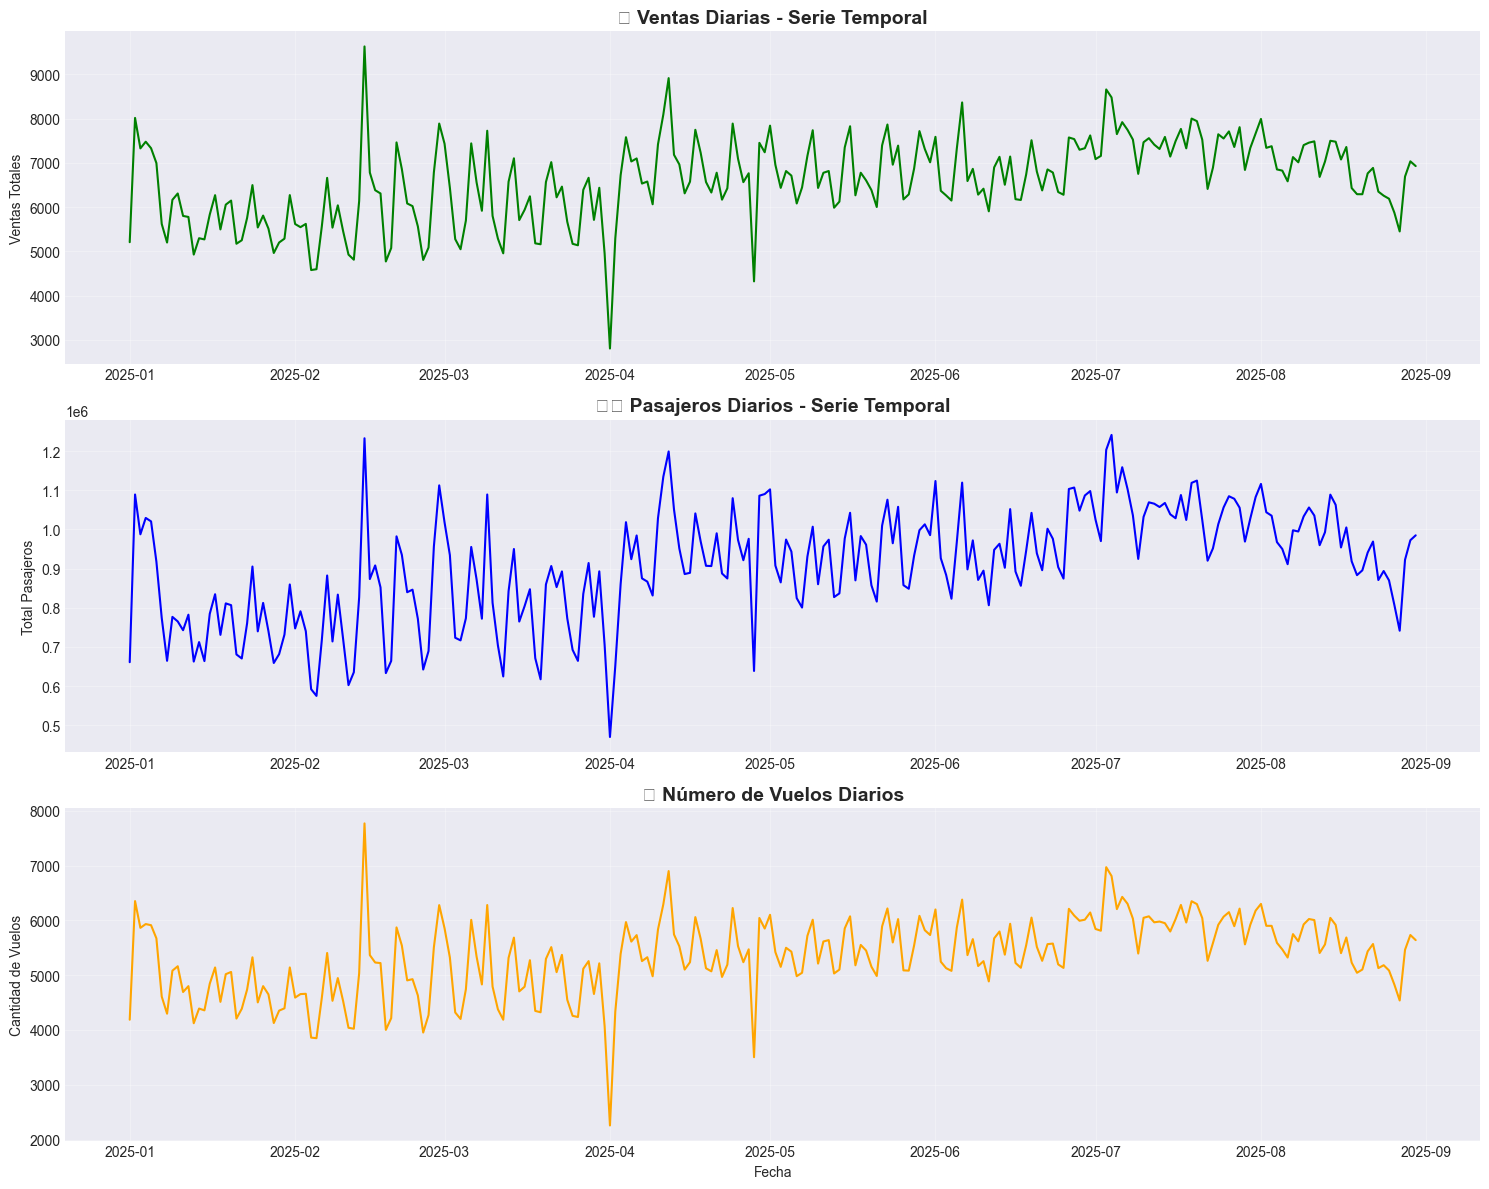

In [7]:
# Visualizar series temporales
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Ventas diarias
axes[0].plot(ts_daily.index, ts_daily['sales'], linewidth=1.5, color='green')
axes[0].set_title('📈 Ventas Diarias - Serie Temporal', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Ventas Totales')
axes[0].grid(True, alpha=0.3)

# Pasajeros diarios
axes[1].plot(ts_daily.index, ts_daily['passengers'], linewidth=1.5, color='blue')
axes[1].set_title('✈️ Pasajeros Diarios - Serie Temporal', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Pasajeros')
axes[1].grid(True, alpha=0.3)

# Número de vuelos diarios
axes[2].plot(ts_daily.index, ts_daily['num_vuelos'], linewidth=1.5, color='orange')
axes[2].set_title('🛫 Número de Vuelos Diarios', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Cantidad de Vuelos')
axes[2].set_xlabel('Fecha')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Descomposición de Series Temporales

🔍 Descomponiendo serie temporal de ventas...


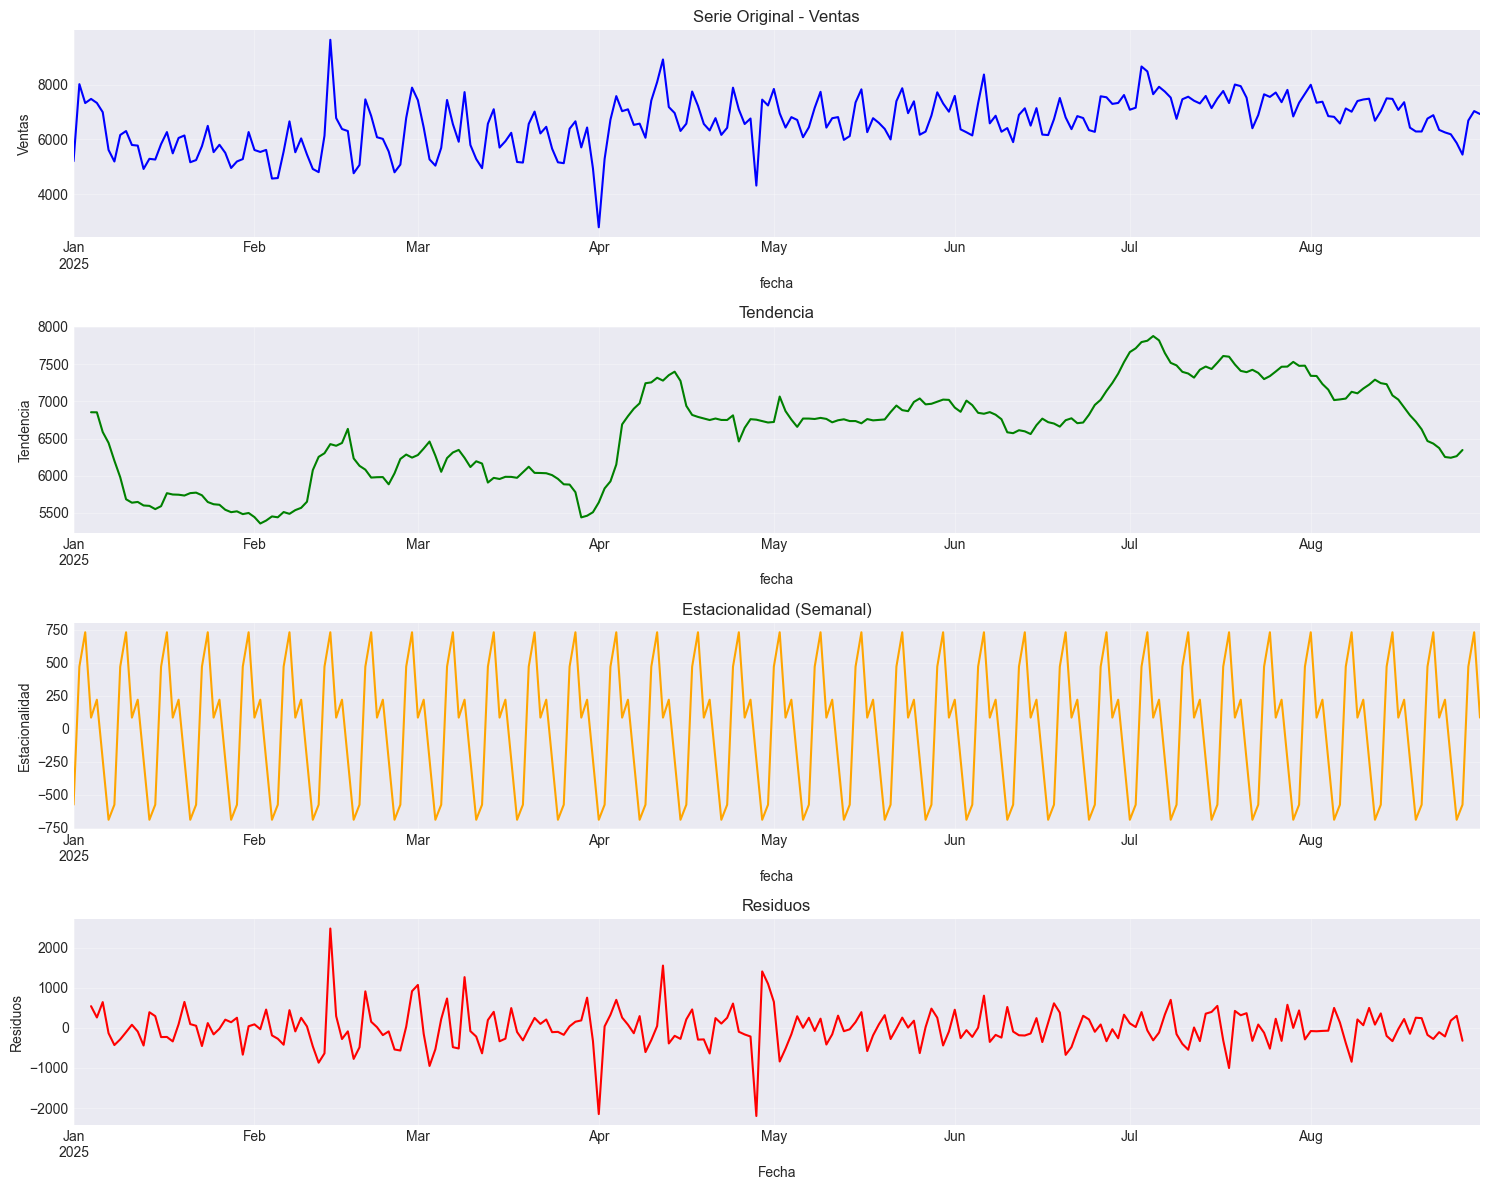

✅ Descomposición completada


In [8]:
# Descomposición de la serie de ventas
print("🔍 Descomponiendo serie temporal de ventas...")

# Usar descomposición aditiva (puede cambiar a 'multiplicative' si es apropiado)
decomposition_sales = seasonal_decompose(ts_daily['sales'], model='additive', period=7)

# Visualizar componentes
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition_sales.observed.plot(ax=axes[0], title='Serie Original - Ventas', color='blue')
axes[0].set_ylabel('Ventas')
axes[0].grid(True, alpha=0.3)

decomposition_sales.trend.plot(ax=axes[1], title='Tendencia', color='green')
axes[1].set_ylabel('Tendencia')
axes[1].grid(True, alpha=0.3)

decomposition_sales.seasonal.plot(ax=axes[2], title='Estacionalidad (Semanal)', color='orange')
axes[2].set_ylabel('Estacionalidad')
axes[2].grid(True, alpha=0.3)

decomposition_sales.resid.plot(ax=axes[3], title='Residuos', color='red')
axes[3].set_ylabel('Residuos')
axes[3].set_xlabel('Fecha')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Descomposición completada")

## 6. Prueba de Estacionariedad (ADF Test)

In [9]:
# Augmented Dickey-Fuller Test
def test_stationarity(timeseries, title='Serie Temporal'):
    print(f"\n{'='*80}")
    print(f"🔬 PRUEBA DE ESTACIONARIEDAD: {title}")
    print(f"{'='*80}")
    
    # Realizar ADF Test
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f"\nADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Lags usados: {result[2]}")
    print(f"Número de observaciones: {result[3]}")
    
    print("\nValores críticos:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    # Interpretación
    if result[1] <= 0.05:
        print("\n✅ CONCLUSIÓN: La serie ES ESTACIONARIA (rechazamos H0)")
    else:
        print("\n⚠️ CONCLUSIÓN: La serie NO ES ESTACIONARIA (no podemos rechazar H0)")
        print("   Recomendación: Aplicar diferenciación")
    
    return result

# Test para ventas
adf_sales = test_stationarity(ts_daily['sales'], 'Ventas Diarias')

# Test para pasajeros
adf_passengers = test_stationarity(ts_daily['passengers'], 'Pasajeros Diarios')


🔬 PRUEBA DE ESTACIONARIEDAD: Ventas Diarias

ADF Statistic: -1.765782
p-value: 0.397577
Lags usados: 14
Número de observaciones: 227

Valores críticos:
  1%: -3.459
  5%: -2.874
  10%: -2.574

⚠️ CONCLUSIÓN: La serie NO ES ESTACIONARIA (no podemos rechazar H0)
   Recomendación: Aplicar diferenciación

🔬 PRUEBA DE ESTACIONARIEDAD: Pasajeros Diarios

ADF Statistic: -1.704706
p-value: 0.428689
Lags usados: 14
Número de observaciones: 227

Valores críticos:
  1%: -3.459
  5%: -2.874
  10%: -2.574

⚠️ CONCLUSIÓN: La serie NO ES ESTACIONARIA (no podemos rechazar H0)
   Recomendación: Aplicar diferenciación


## 7. ACF y PACF (Autocorrelación)

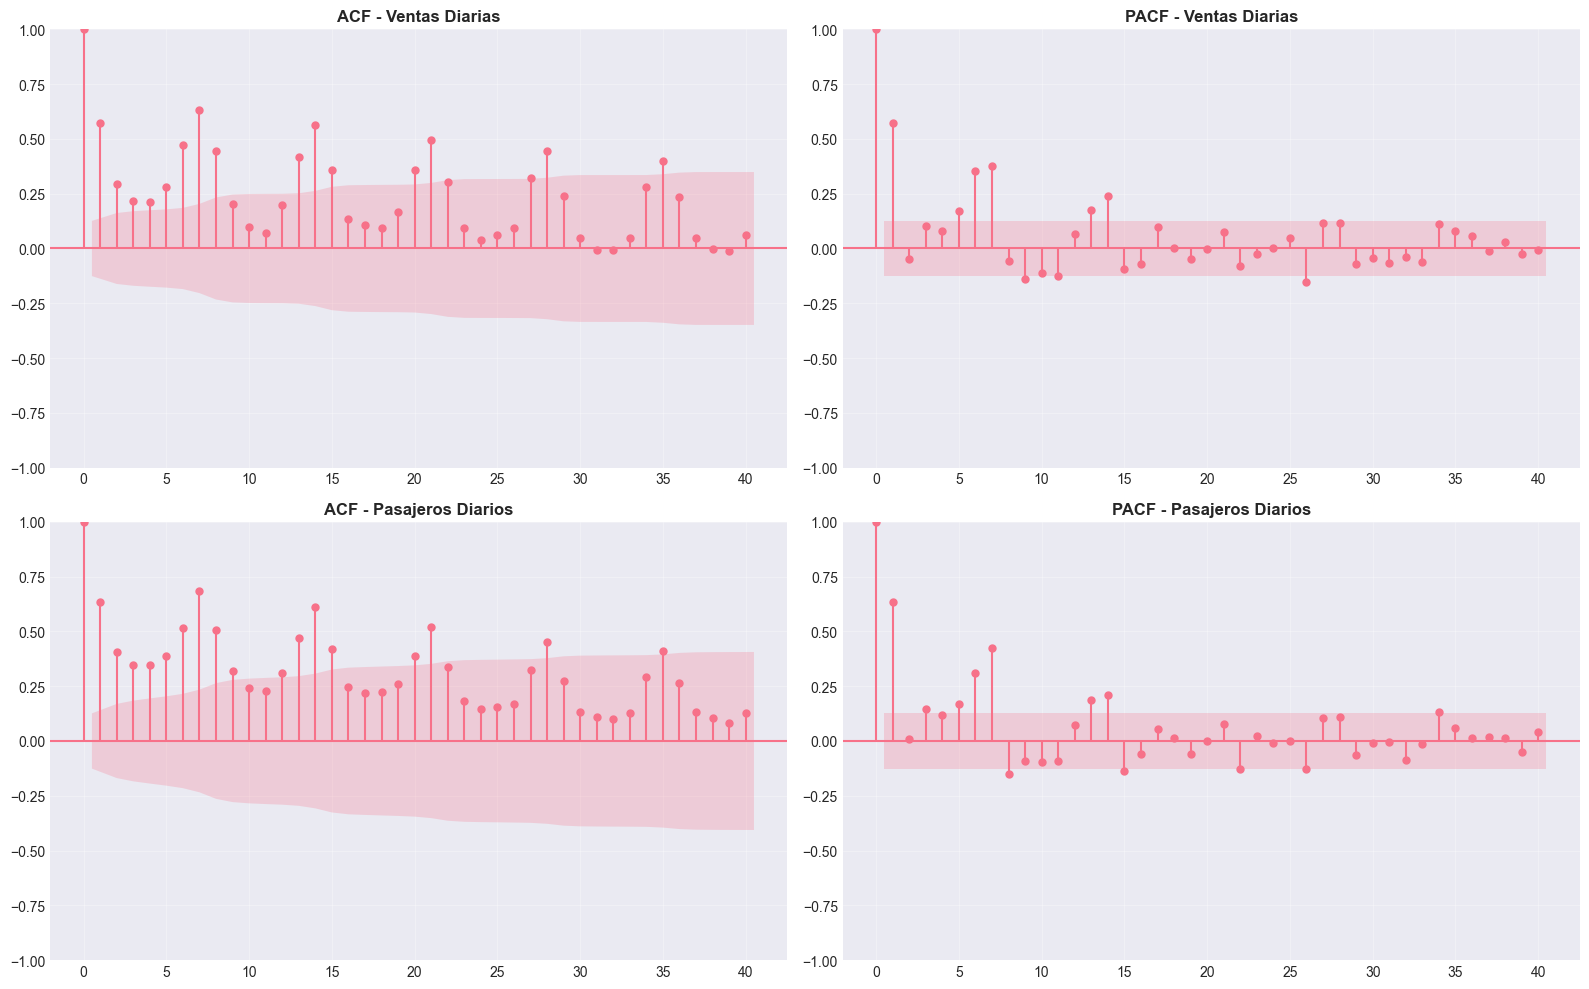

In [10]:
# Gráficos ACF y PACF para ventas
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Ventas - ACF
plot_acf(ts_daily['sales'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF - Ventas Diarias', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Ventas - PACF
plot_pacf(ts_daily['sales'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF - Ventas Diarias', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Pasajeros - ACF
plot_acf(ts_daily['passengers'].dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Pasajeros Diarios', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Pasajeros - PACF
plot_pacf(ts_daily['passengers'].dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF - Pasajeros Diarios', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. División Train/Test

📊 DIVISIÓN DE DATOS
Total de observaciones: 242 días

Train set:
  - Tamaño: 193 días (79.8%)
  - Período: 2025-01-01 00:00:00 a 2025-07-12 00:00:00

Test set:
  - Tamaño: 49 días (20.2%)
  - Período: 2025-07-13 00:00:00 a 2025-08-30 00:00:00


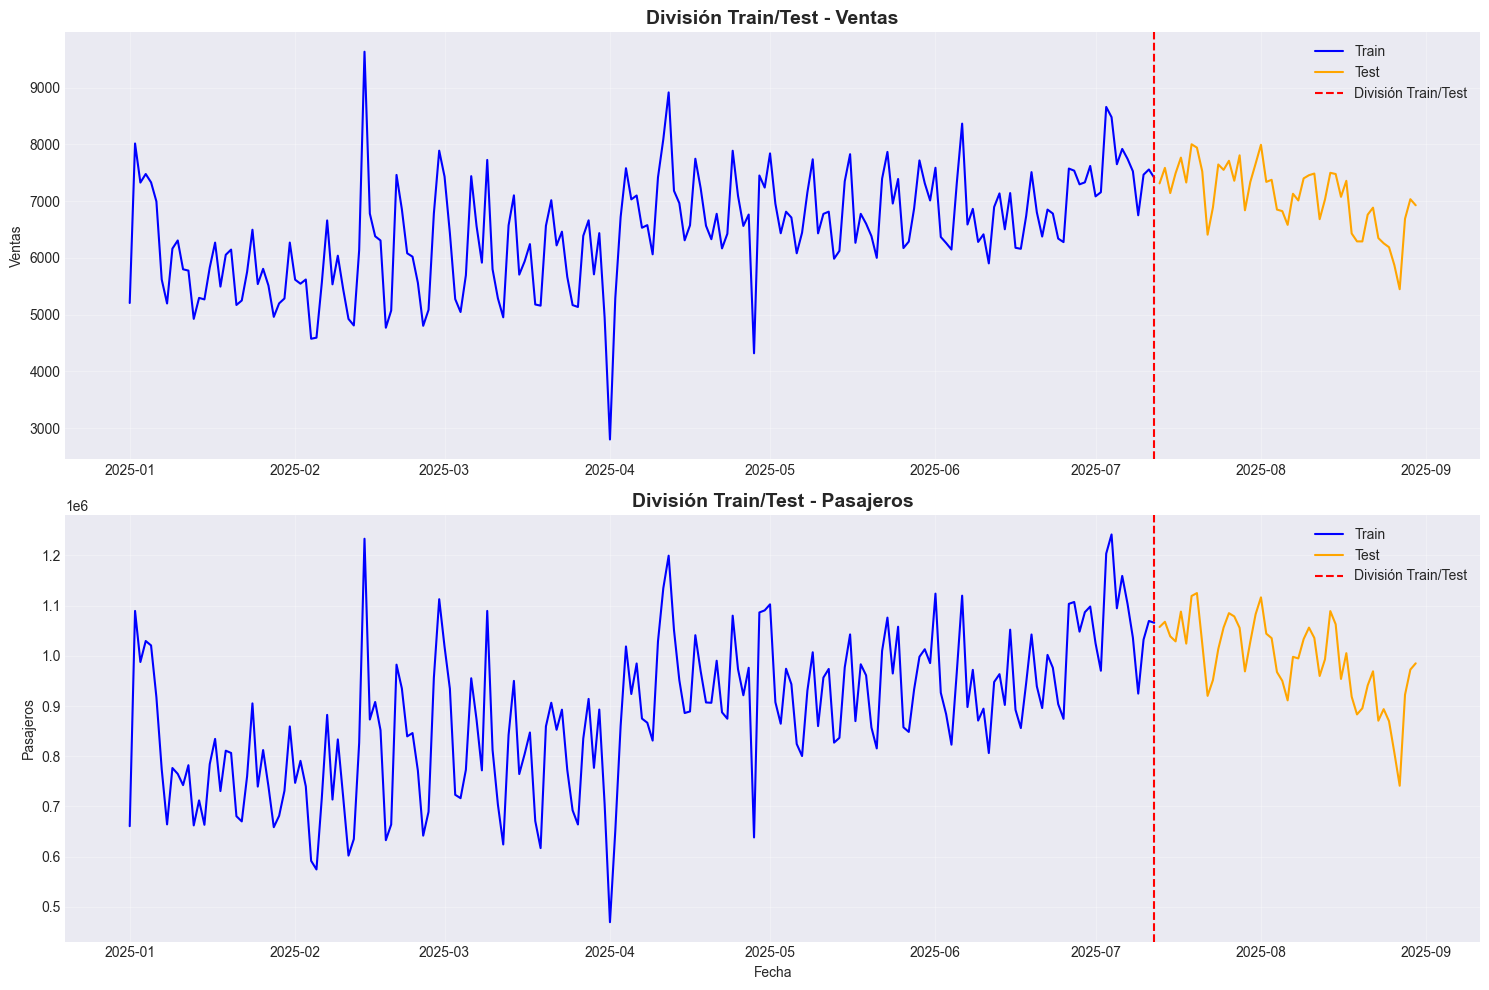

In [11]:
# Dividir en train y test (80/20)
train_size = int(len(ts_daily) * 0.8)

train = ts_daily[:train_size]
test = ts_daily[train_size:]

print(f"📊 DIVISIÓN DE DATOS")
print(f"="*80)
print(f"Total de observaciones: {len(ts_daily)} días")
print(f"\nTrain set:")
print(f"  - Tamaño: {len(train)} días ({len(train)/len(ts_daily)*100:.1f}%)")
print(f"  - Período: {train.index[0]} a {train.index[-1]}")
print(f"\nTest set:")
print(f"  - Tamaño: {len(test)} días ({len(test)/len(ts_daily)*100:.1f}%)")
print(f"  - Período: {test.index[0]} a {test.index[-1]}")

# Visualizar división
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Ventas
axes[0].plot(train.index, train['sales'], label='Train', color='blue', linewidth=1.5)
axes[0].plot(test.index, test['sales'], label='Test', color='orange', linewidth=1.5)
axes[0].axvline(x=train.index[-1], color='red', linestyle='--', label='División Train/Test')
axes[0].set_title('División Train/Test - Ventas', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Ventas')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Pasajeros
axes[1].plot(train.index, train['passengers'], label='Train', color='blue', linewidth=1.5)
axes[1].plot(test.index, test['passengers'], label='Test', color='orange', linewidth=1.5)
axes[1].axvline(x=train.index[-1], color='red', linestyle='--', label='División Train/Test')
axes[1].set_title('División Train/Test - Pasajeros', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Pasajeros')
axes[1].set_xlabel('Fecha')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Modelo ARIMA - Ventas

In [12]:
# Entrenar modelo ARIMA para ventas
print("🤖 Entrenando modelo ARIMA para ventas...")
print("Esto puede tomar unos momentos...\n")

# Parámetros ARIMA (p, d, q)
# p: orden autoregresivo, d: diferenciación, q: media móvil
order = (1, 1, 1)  # Puedes ajustar estos parámetros

model_arima_sales = ARIMA(train['sales'], order=order)
fitted_arima_sales = model_arima_sales.fit()

print("✅ Modelo ARIMA entrenado")
print("\n" + "="*80)
print("RESUMEN DEL MODELO")
print("="*80)
print(fitted_arima_sales.summary())

🤖 Entrenando modelo ARIMA para ventas...
Esto puede tomar unos momentos...

✅ Modelo ARIMA entrenado

RESUMEN DEL MODELO
                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  193
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1559.531
Date:                Sat, 25 Oct 2025   AIC                           3125.062
Time:                        23:25:41   BIC                           3134.835
Sample:                    01-01-2025   HQIC                          3129.020
                         - 07-12-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4230      0.069      6.166      0.000       0.289       0.557
ma.L1     

In [13]:
# Predicciones
predictions_arima = fitted_arima_sales.forecast(steps=len(test))

# Calcular métricas
mae = mean_absolute_error(test['sales'], predictions_arima)
rmse = np.sqrt(mean_squared_error(test['sales'], predictions_arima))
r2 = r2_score(test['sales'], predictions_arima)

print(f"📊 MÉTRICAS DEL MODELO ARIMA - VENTAS")
print(f"="*80)
print(f"MAE (Mean Absolute Error): {mae:,.2f}")
print(f"RMSE (Root Mean Squared Error): {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"\nError promedio: {mae/test['sales'].mean()*100:.2f}% del valor promedio")

📊 MÉTRICAS DEL MODELO ARIMA - VENTAS
MAE (Mean Absolute Error): 461.12
RMSE (Root Mean Squared Error): 576.61
R² Score: -0.0339

Error promedio: 6.50% del valor promedio


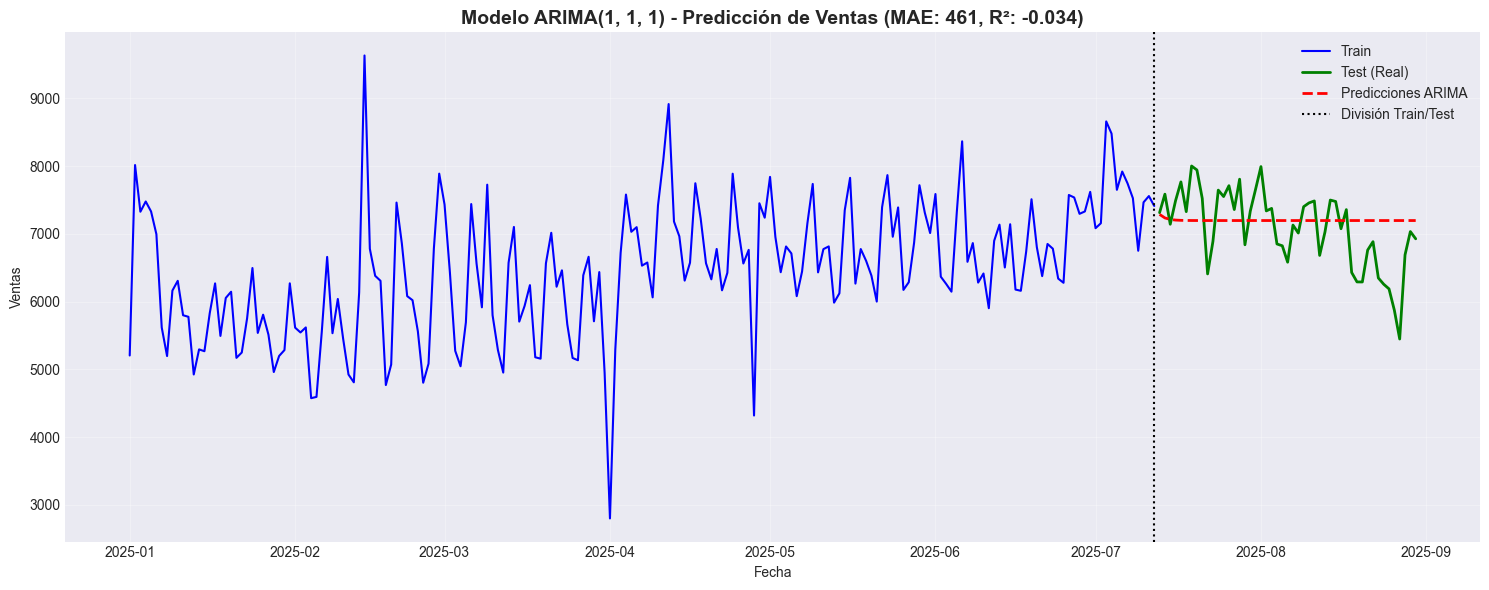

In [14]:
# Visualizar predicciones
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['sales'], label='Train', color='blue', linewidth=1.5)
plt.plot(test.index, test['sales'], label='Test (Real)', color='green', linewidth=2)
plt.plot(test.index, predictions_arima, label='Predicciones ARIMA', color='red', linewidth=2, linestyle='--')
plt.axvline(x=train.index[-1], color='black', linestyle=':', label='División Train/Test')
plt.title(f'Modelo ARIMA{order} - Predicción de Ventas (MAE: {mae:,.0f}, R²: {r2:.3f})', 
          fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Modelo SARIMA - Ventas (con estacionalidad)

In [15]:
# Entrenar modelo SARIMA (incluye estacionalidad semanal)
print("🤖 Entrenando modelo SARIMA con estacionalidad semanal...")
print("Esto puede tomar varios minutos...\n")

# Parámetros SARIMA (p,d,q) x (P,D,Q,s)
# s=7 para estacionalidad semanal
order_sarima = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

model_sarima_sales = SARIMAX(train['sales'], 
                              order=order_sarima,
                              seasonal_order=seasonal_order)
fitted_sarima_sales = model_sarima_sales.fit(disp=False)

print("✅ Modelo SARIMA entrenado")
print("\n" + "="*80)
print("RESUMEN DEL MODELO SARIMA")
print("="*80)
print(fitted_sarima_sales.summary())

🤖 Entrenando modelo SARIMA con estacionalidad semanal...
Esto puede tomar varios minutos...

✅ Modelo SARIMA entrenado

RESUMEN DEL MODELO SARIMA
                                     SARIMAX Results                                     
Dep. Variable:                             sales   No. Observations:                  193
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1458.817
Date:                           Sat, 25 Oct 2025   AIC                           2927.634
Time:                                   23:25:42   BIC                           2943.736
Sample:                               01-01-2025   HQIC                          2934.159
                                    - 07-12-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [16]:
# Predicciones SARIMA
predictions_sarima = fitted_sarima_sales.forecast(steps=len(test))

# Métricas
mae_sarima = mean_absolute_error(test['sales'], predictions_sarima)
rmse_sarima = np.sqrt(mean_squared_error(test['sales'], predictions_sarima))
r2_sarima = r2_score(test['sales'], predictions_sarima)

print(f"📊 MÉTRICAS DEL MODELO SARIMA - VENTAS")
print(f"="*80)
print(f"MAE: {mae_sarima:,.2f}")
print(f"RMSE: {rmse_sarima:,.2f}")
print(f"R² Score: {r2_sarima:.4f}")
print(f"\nError promedio: {mae_sarima/test['sales'].mean()*100:.2f}%")

print(f"\n📈 COMPARACIÓN ARIMA vs SARIMA:")
print(f"  ARIMA  - MAE: {mae:,.2f}, R²: {r2:.4f}")
print(f"  SARIMA - MAE: {mae_sarima:,.2f}, R²: {r2_sarima:.4f}")
mejora = ((mae - mae_sarima) / mae * 100)
print(f"  Mejora: {mejora:.2f}% {'(SARIMA mejor)' if mejora > 0 else '(ARIMA mejor)'}")

📊 MÉTRICAS DEL MODELO SARIMA - VENTAS
MAE: 635.12
RMSE: 785.48
R² Score: -0.9186

Error promedio: 8.96%

📈 COMPARACIÓN ARIMA vs SARIMA:
  ARIMA  - MAE: 461.12, R²: -0.0339
  SARIMA - MAE: 635.12, R²: -0.9186
  Mejora: -37.74% (ARIMA mejor)


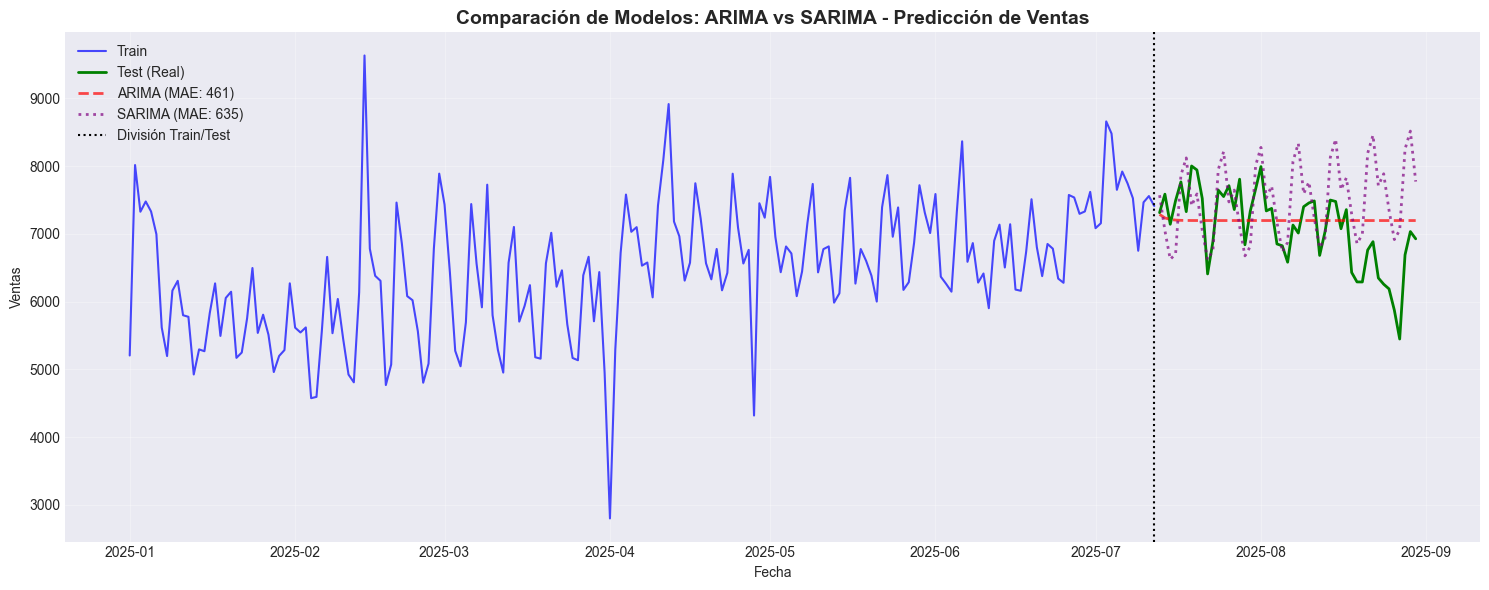

In [17]:
# Visualizar comparación
plt.figure(figsize=(15, 6))
plt.plot(train.index, train['sales'], label='Train', color='blue', linewidth=1.5, alpha=0.7)
plt.plot(test.index, test['sales'], label='Test (Real)', color='green', linewidth=2)
plt.plot(test.index, predictions_arima, label=f'ARIMA (MAE: {mae:,.0f})', 
         color='red', linewidth=2, linestyle='--', alpha=0.7)
plt.plot(test.index, predictions_sarima, label=f'SARIMA (MAE: {mae_sarima:,.0f})', 
         color='purple', linewidth=2, linestyle=':', alpha=0.7)
plt.axvline(x=train.index[-1], color='black', linestyle=':', label='División Train/Test')
plt.title('Comparación de Modelos: ARIMA vs SARIMA - Predicción de Ventas', 
          fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Exponential Smoothing (Holt-Winters)

In [18]:
# Modelo Exponential Smoothing con estacionalidad
print("🤖 Entrenando modelo Exponential Smoothing (Holt-Winters)...\n")

model_hw = ExponentialSmoothing(train['sales'], 
                                 seasonal_periods=7,
                                 trend='add',
                                 seasonal='add')
fitted_hw = model_hw.fit()

# Predicciones
predictions_hw = fitted_hw.forecast(steps=len(test))

# Métricas
mae_hw = mean_absolute_error(test['sales'], predictions_hw)
rmse_hw = np.sqrt(mean_squared_error(test['sales'], predictions_hw))
r2_hw = r2_score(test['sales'], predictions_hw)

print("✅ Modelo Exponential Smoothing entrenado")
print(f"\n📊 MÉTRICAS - EXPONENTIAL SMOOTHING")
print(f"="*80)
print(f"MAE: {mae_hw:,.2f}")
print(f"RMSE: {rmse_hw:,.2f}")
print(f"R² Score: {r2_hw:.4f}")

🤖 Entrenando modelo Exponential Smoothing (Holt-Winters)...

✅ Modelo Exponential Smoothing entrenado

📊 MÉTRICAS - EXPONENTIAL SMOOTHING
MAE: 575.84
RMSE: 706.29
R² Score: -0.5513


## 12. Comparación Final de Todos los Modelos

In [19]:
# Tabla comparativa
resultados = pd.DataFrame({
    'Modelo': ['ARIMA', 'SARIMA', 'Exponential Smoothing'],
    'MAE': [mae, mae_sarima, mae_hw],
    'RMSE': [rmse, rmse_sarima, rmse_hw],
    'R²': [r2, r2_sarima, r2_hw]
})

resultados['Error_%'] = (resultados['MAE'] / test['sales'].mean() * 100).round(2)
resultados = resultados.sort_values('MAE')

print("\n" + "="*80)
print("🏆 COMPARACIÓN FINAL DE MODELOS")
print("="*80)
print(resultados.to_string(index=False))
print("\n" + "="*80)
print(f"🥇 MEJOR MODELO: {resultados.iloc[0]['Modelo']}")
print(f"   MAE: {resultados.iloc[0]['MAE']:,.2f}")
print(f"   R²: {resultados.iloc[0]['R²']:.4f}")
print("="*80)


🏆 COMPARACIÓN FINAL DE MODELOS
               Modelo        MAE       RMSE        R²  Error_%
                ARIMA 461.115822 576.612571 -0.033918     6.50
Exponential Smoothing 575.841027 706.292009 -0.551267     8.12
               SARIMA 635.121625 785.479171 -0.918613     8.96

🥇 MEJOR MODELO: ARIMA
   MAE: 461.12
   R²: -0.0339


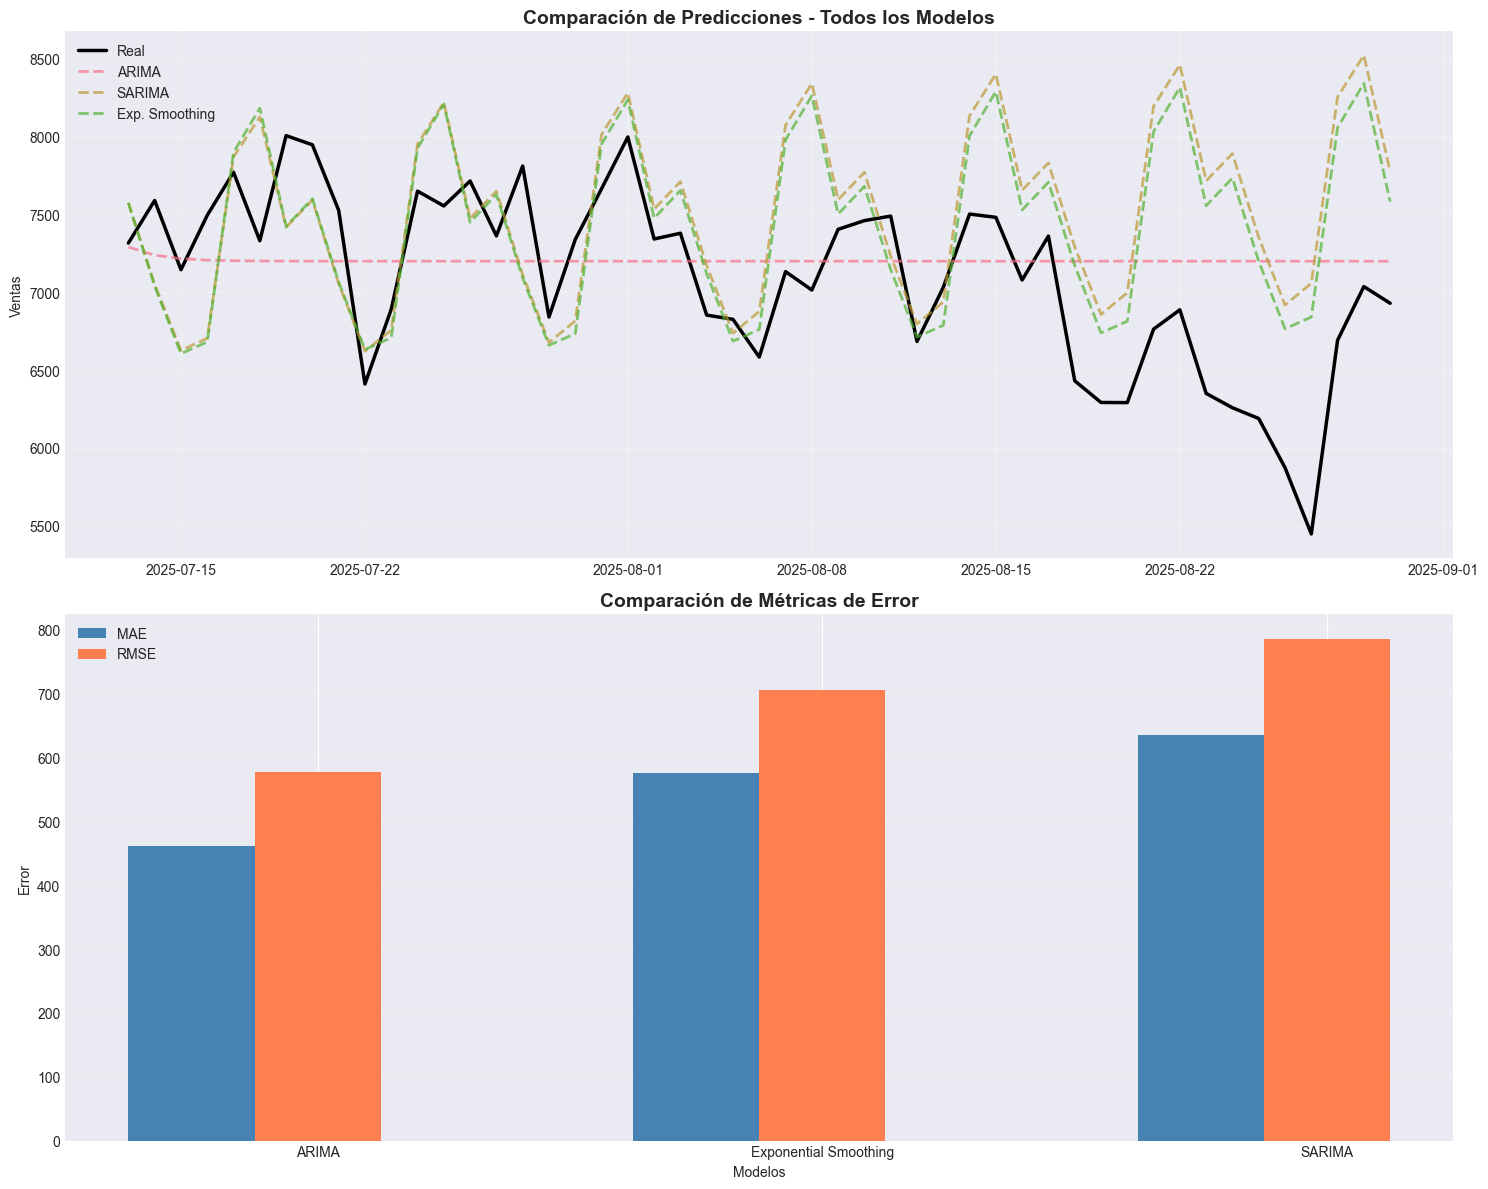

In [20]:
# Visualización final comparativa
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Gráfico 1: Comparación de predicciones
axes[0].plot(test.index, test['sales'], label='Real', color='black', linewidth=2.5)
axes[0].plot(test.index, predictions_arima, label='ARIMA', linestyle='--', linewidth=2, alpha=0.7)
axes[0].plot(test.index, predictions_sarima, label='SARIMA', linestyle='--', linewidth=2, alpha=0.7)
axes[0].plot(test.index, predictions_hw, label='Exp. Smoothing', linestyle='--', linewidth=2, alpha=0.7)
axes[0].set_title('Comparación de Predicciones - Todos los Modelos', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Ventas')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Comparación de métricas
x = np.arange(len(resultados))
width = 0.25

axes[1].bar(x - width, resultados['MAE'], width, label='MAE', color='steelblue')
axes[1].bar(x, resultados['RMSE'], width, label='RMSE', color='coral')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Error')
axes[1].set_title('Comparación de Métricas de Error', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(resultados['Modelo'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 13. Forecast Futuro (Próximos 30 días)

In [21]:
# Usar el mejor modelo para predecir los próximos 30 días
print("🔮 Generando forecast para los próximos 30 días...\n")

# Reentrenar con todos los datos disponibles
model_final = SARIMAX(ts_daily['sales'], 
                      order=order_sarima,
                      seasonal_order=seasonal_order)
fitted_final = model_final.fit(disp=False)

# Predecir próximos 30 días
forecast_days = 30
forecast = fitted_final.forecast(steps=forecast_days)

# Crear fechas futuras
last_date = ts_daily.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=forecast_days, freq='D')

# DataFrame de forecast
df_forecast = pd.DataFrame({
    'fecha': future_dates,
    'ventas_predichas': forecast.values
})

print("✅ Forecast generado")
print(f"\n📅 Predicciones para los próximos {forecast_days} días:")
print(f"Desde: {future_dates[0].strftime('%Y-%m-%d')}")
print(f"Hasta: {future_dates[-1].strftime('%Y-%m-%d')}")
print(f"\nVentas promedio predichas: {forecast.mean():,.2f}")
print(f"Ventas totales predichas: {forecast.sum():,.2f}")

display(df_forecast.head(10))

🔮 Generando forecast para los próximos 30 días...

✅ Forecast generado

📅 Predicciones para los próximos 30 días:
Desde: 2025-08-31
Hasta: 2025-09-29

Ventas promedio predichas: 6,413.18
Ventas totales predichas: 192,395.34


,fecha,ventas_predichas
0,2025-08-31,6763.328468
1,2025-09-01,6359.918943
2,2025-09-02,5940.078645
3,2025-09-03,5982.878985
4,2025-09-04,6860.158518
5,2025-09-05,6955.841675
6,2025-09-06,6575.617810
7,2025-09-07,6649.224871
8,2025-09-08,6300.111362
9,2025-09-09,5894.233828


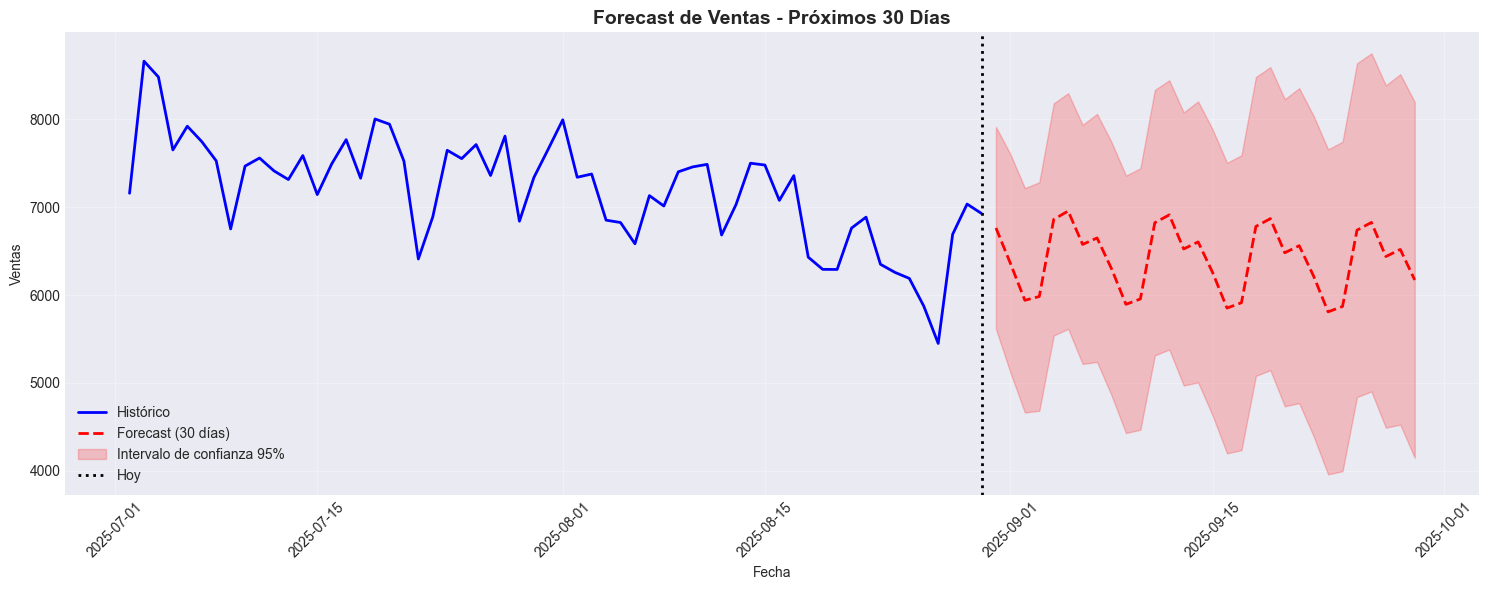

In [22]:
# Visualizar forecast
plt.figure(figsize=(15, 6))

# Últimos 60 días históricos
plt.plot(ts_daily.index[-60:], ts_daily['sales'][-60:], 
         label='Histórico', color='blue', linewidth=2)

# Forecast
plt.plot(future_dates, forecast, 
         label='Forecast (30 días)', color='red', linewidth=2, linestyle='--')

# Intervalo de confianza (opcional)
forecast_ci = fitted_final.get_forecast(steps=forecast_days).conf_int()
plt.fill_between(future_dates, 
                  forecast_ci.iloc[:, 0], 
                  forecast_ci.iloc[:, 1], 
                  color='red', alpha=0.2, label='Intervalo de confianza 95%')

plt.axvline(x=last_date, color='black', linestyle=':', linewidth=2, label='Hoy')
plt.title('Forecast de Ventas - Próximos 30 Días', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 14. Guardar Resultados

In [23]:
# Guardar forecast en CSV
df_forecast.to_csv(r'Data\Clean\forecast_ventas_30dias.csv', index=False)
print("✅ Forecast guardado en: Data\\Clean\\forecast_ventas_30dias.csv")

# Guardar métricas de modelos
resultados.to_csv(r'Data\\Clean\\metricas_modelos.csv', index=False)
print("✅ Métricas guardadas en: Data\\Clean\\metricas_modelos.csv")

print("\n" + "="*80)
print("🎉 ANÁLISIS DE SERIES TEMPORALES COMPLETADO")
print("="*80)

✅ Forecast guardado en: Data\Clean\forecast_ventas_30dias.csv
✅ Métricas guardadas en: Data\Clean\metricas_modelos.csv

🎉 ANÁLISIS DE SERIES TEMPORALES COMPLETADO
